In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
# ------------------ Load Datasets ------------------ #
heart_2022_with_nans = '/content/drive/My Drive/Life expectancy - Final Project/Data/heart_2022_with_nans.csv'
averageLE = '/content/drive/My Drive/Life expectancy - Final Project/Data/xmart.csv'

df = pd.read_csv(heart_2022_with_nans)
averageLE = pd.read_csv(averageLE)

In [9]:
# Average Life Expectancy Data
averageLE = averageLE[['Life expectancy at birth (years)  Male',
                       'Life expectancy at birth (years)  Female',
                       'Life expectancy at age 60 (years)  Male',
                       'Life expectancy at age 60 (years)  Female']]

averageLE = averageLE.rename(columns={
    'Life expectancy at birth (years)  Male': 'LE_birth_male',
    'Life expectancy at birth (years)  Female': 'LE_birth_female',
    'Life expectancy at age 60 (years)  Male': 'LE_60_male',
    'Life expectancy at age 60 (years)  Female': 'LE_60_female'
})

life_expectancy_stats = {
    col: {
        'min': averageLE[col].min(),
        'max': averageLE[col].max(),
        'mean': averageLE[col].mean()
    }
    for col in averageLE.columns
}
"""

{'LE_birth_male': {'min': 28.0,
                   'max': 81.8,
                   'mean': np.float64(67.76898907103826)},
 'LE_birth_female': {'min': 35.4,
                     'max': 86.9,
                    'mean': np.float64(72.69275956284153)},
'LE_60_male': {'min': 10.1,
               'max': 24.4,
               'mean': np.float64(17.65122950819672)},
'LE_60_female': {'min': 12.0,
                 'max': 28.6,
                 'mean': np.float64(20.513387978142074)}}
"""

"\n\n{'LE_birth_male': {'min': 28.0,\n                   'max': 81.8,\n                   'mean': np.float64(67.76898907103826)},\n 'LE_birth_female': {'min': 35.4,\n                     'max': 86.9,\n                    'mean': np.float64(72.69275956284153)},\n'LE_60_male': {'min': 10.1,\n               'max': 24.4,\n               'mean': np.float64(17.65122950819672)},\n'LE_60_female': {'min': 12.0,\n                 'max': 28.6,\n                 'mean': np.float64(20.513387978142074)}}\n"

In [10]:
#Drop Unnecessary Columns
df = df.drop(['MentalHealthDays','PhysicalHealthDays','State', 'GeneralHealth','RemovedTeeth','LastCheckupTime','ChestScan','HeightInMeters','WeightInKilograms','HadSkinCancer','HIVTesting','CovidPos','RaceEthnicityCategory'], axis=1)
df = df.dropna()


In [14]:
#Convert Data to numerical representation


#Yes/No
df.replace({"Yes": 1, "No": 0},inplace=True)



df.replace({"Male": 0, "Female": 1},inplace=True)


#SmokingStatus
df['SmokerStatus'].replace(
    [
        "Never smoked",
        "Former smoker",
        "Current smoker - now smokes some days",
        "Current smoker - now smokes every day"
    ],
    [0, 1, 2, 4],
    inplace=True
)
#ECigaretteUsage
df['ECigaretteUsage'].replace(
    [
        "Never used e-cigarettes in my entire life",
        "Not at all (right now)",
        "Use them some days",
        "Use them every day"
    ],
    [0, 1, 2, 3],
    inplace=True
)

#TetanusLast10Tdap
df['TetanusLast10Tdap'].replace(
    [
        "No, did not receive any tetanus shot in the past 10 years",
        "Yes, received tetanus shot but not sure what type",
        "Yes, received Tdap",
        "Yes, received tetanus shot, but not Tdap"
    ],
    [0, 1, 2, 3],
    inplace=True
)


age_map = {
    'Age 18 to 24': 18,
    'Age 25 to 29': 25,
    'Age 30 to 34': 30,
    'Age 35 to 39': 35,
    'Age 40 to 44': 40,
    'Age 45 to 49': 45,
    'Age 50 to 54': 50,
    'Age 55 to 59': 55,
    'Age 60 to 64': 60,
    'Age 65 to 69': 65,
    'Age 70 to 74': 70,
    'Age 75 to 79': 75,
    'Age 80 or older': 80
}

# for reproducibility
np.random.seed(0)

df = df.rename(columns={'AgeCategory': 'Age'})
df['Age'] = (
    df['Age']
      .map(age_map)
      + np.random.randint(0, 5, size=len(df))
)

df = df[pd.to_numeric(df.stack(), errors='coerce').unstack().notna().all(axis=1)]

<ipython-input-14-1a6e18f6c2fe>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"Yes": 1, "No": 0},inplace=True)
<ipython-input-14-1a6e18f6c2fe>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"Male": 0, "Female": 1},inplace=True)
<ipython-input-14-1a6e18f6c2fe>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

In [15]:
import numpy as np

def calculate_life_expectancy(row, life_expectancy_stats):
    """
    Calculate an individual’s life expectancy based on:
      - Official life-table means/min/max
      - Jittered base expectancy
      - Merged & capped penalties (max 30 years)
      - Small random shrink on penalties
      - Final ±1 year of noise
      - Distinct smoker‐status penalties
    """

    # ——————————————————————————
    # 1) Determine which life-table category and offset
    sex = 'male' if row['Sex'] == 0 else 'female'
    is_60_plus = row['Age'] >= 60
    category = f"LE_60_{sex}" if is_60_plus else f"LE_birth_{sex}"
    stats   = life_expectancy_stats[category]
    offset  = 60 if is_60_plus else 0

    # ——————————————————————————
    # 2) Build a jittered “base” expectancy around the official mean
    base_mean = stats['mean'] + offset
    base      = np.random.normal(loc=base_mean, scale=2)  # ±2 years scatter

    adjustment = 0.0
    penalties  = []

    # ——————————————————————————
    # 3) Smoking‐status penalty (4 levels)
    ss = row.get('SmokerStatus', 0)
    if ss == 1:
        # former smoker
        penalties.append(np.random.uniform(1.4, 5.6))
    elif ss == 2:
        # current occasional smoker
        penalties.append(np.random.uniform(2.2, 5.8))
    elif ss in (3, 4):
        # current everyday smoker
        penalties.append(np.random.uniform(6.8, 8.8))
    # ss == 0 → never smoked → no penalty

    # 4) Alcohol penalty (if you still want it separate)
    if row.get('AlcoholDrinkers', 0) == 1:
        penalties.append(np.random.uniform(2, 4))

    # 5) Physical activity benefit
    if row.get('PhysicalActivities', 0) == 1:
        adjustment += np.random.uniform(0.4, 6.9)

    # 6) Sleep penalty
    sh = row.get('SleepHours', 7)
    if sh < 7 or sh > 9:
        penalties.append(np.random.uniform(1, 3))

    # ——————————————————————————
    # 7) Disease penalties (merged + scale if many)
    disease_penalties = {
        'HadHeartAttack':        12,
        'HadStroke':             np.random.uniform(5.5, 7.4),
        'HadDiabetes':           6,
        'HadCOPD':               np.random.uniform(2.2, 5.8),
        'HadAsthma':             3.3,
        'HadDepressiveDisorder': np.random.uniform(12, 21),
        'HadKidneyDisease':      6,
        'HadArthritis':          np.random.uniform(0, 10),
    }
    dcount = 0
    for disease, pen in disease_penalties.items():
        if row.get(disease, 0) == 1:
            penalties.append(pen)
            dcount += 1
    if dcount > 3:
        penalties = [p * 0.75 for p in penalties]

    # ——————————————————————————
    # 8) Disability (merged)
    disabilities = [
        'DifficultyConcentrating','DifficultyWalking',
        'DifficultyDressingBathing','DifficultyErrands'
    ]
    if any(row.get(d, 0) == 1 for d in disabilities):
        penalties.append(np.random.uniform(0, 10))

    # ——————————————————————————
    # 9) Vaccination “bonus” (merged)
    vax_keys = ['FluVaxLast12','PneumoVaxEver','TetanusLast10Tdap']
    vax_count = sum(int(row.get(k, 0)) for k in vax_keys)
    if vax_count > 0:
        adjustment += np.random.uniform(2, 10)

    # ——————————————————————————
    # 10) BMI penalties
    bmi = row.get('BMI', 25)
    if bmi >= 30:
        penalties.append(4.2 if sex == 'male' else 3.5)
    elif bmi < 18.5:
        penalties.append(4.3 if sex == 'male' else 4.5)

    # ——————————————————————————
    # 11) Combine & cap total penalty at 30 years, then shrink 80–100%
    total_penalty = min(sum(penalties), 30)
    total_penalty *= np.random.uniform(0.8, 1.0)

    # ——————————————————————————
    # 12) Final estimate + ±1 year noise
    estimate = base + adjustment - total_penalty
    estimate += np.random.normal(0, 1)

    # ——————————————————————————
    # 13) Clamp to official min/max bounds
    min_allowed = stats['min'] + offset
    max_allowed = stats['max'] + offset
    estimate = float(np.clip(estimate, min_allowed, max_allowed))

    return estimate

# Apply to your DataFrame:
df['LifeExpectancy'] = df.apply(
    lambda r: calculate_life_expectancy(r, life_expectancy_stats),
    axis=1
)

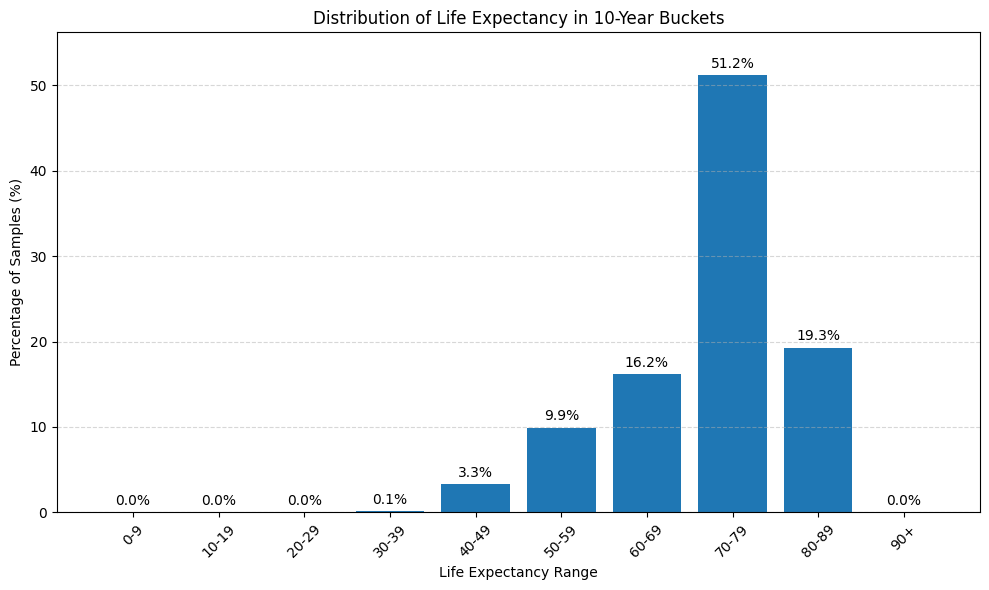

In [16]:
life_expectancy = df["LifeExpectancy"]

bins = list(range(0, 101, 10))
labels = [f"{i}-{i+9}" for i in bins[:-1]]
labels[-1] = "90+"

bucketed = pd.cut(life_expectancy, bins=[0,10,20,30,40,50,60,70,80,90,200], labels=labels, right=True, include_lowest=True)

percentages = bucketed.value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(percentages.index, percentages.values)
plt.xlabel("Life Expectancy Range")
plt.ylabel("Percentage of Samples (%)")
plt.title("Distribution of Life Expectancy in 10-Year Buckets")
plt.ylim(0, percentages.max() + 5)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

<ipython-input-17-974229be9c22>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mean_vals, x=col, y='LifeExpectancy', palette='viridis')
<ipython-input-17-974229be9c22>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mean_vals, x=col, y='LifeExpectancy', palette='viridis')
<ipython-input-17-974229be9c22>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mean_vals, x=col, y='LifeExpectancy', palette='viridis')
<ipython-input-17-974229be9c22>:25: FutureWarning: 

Passing `palette` without assigning `hue` is de

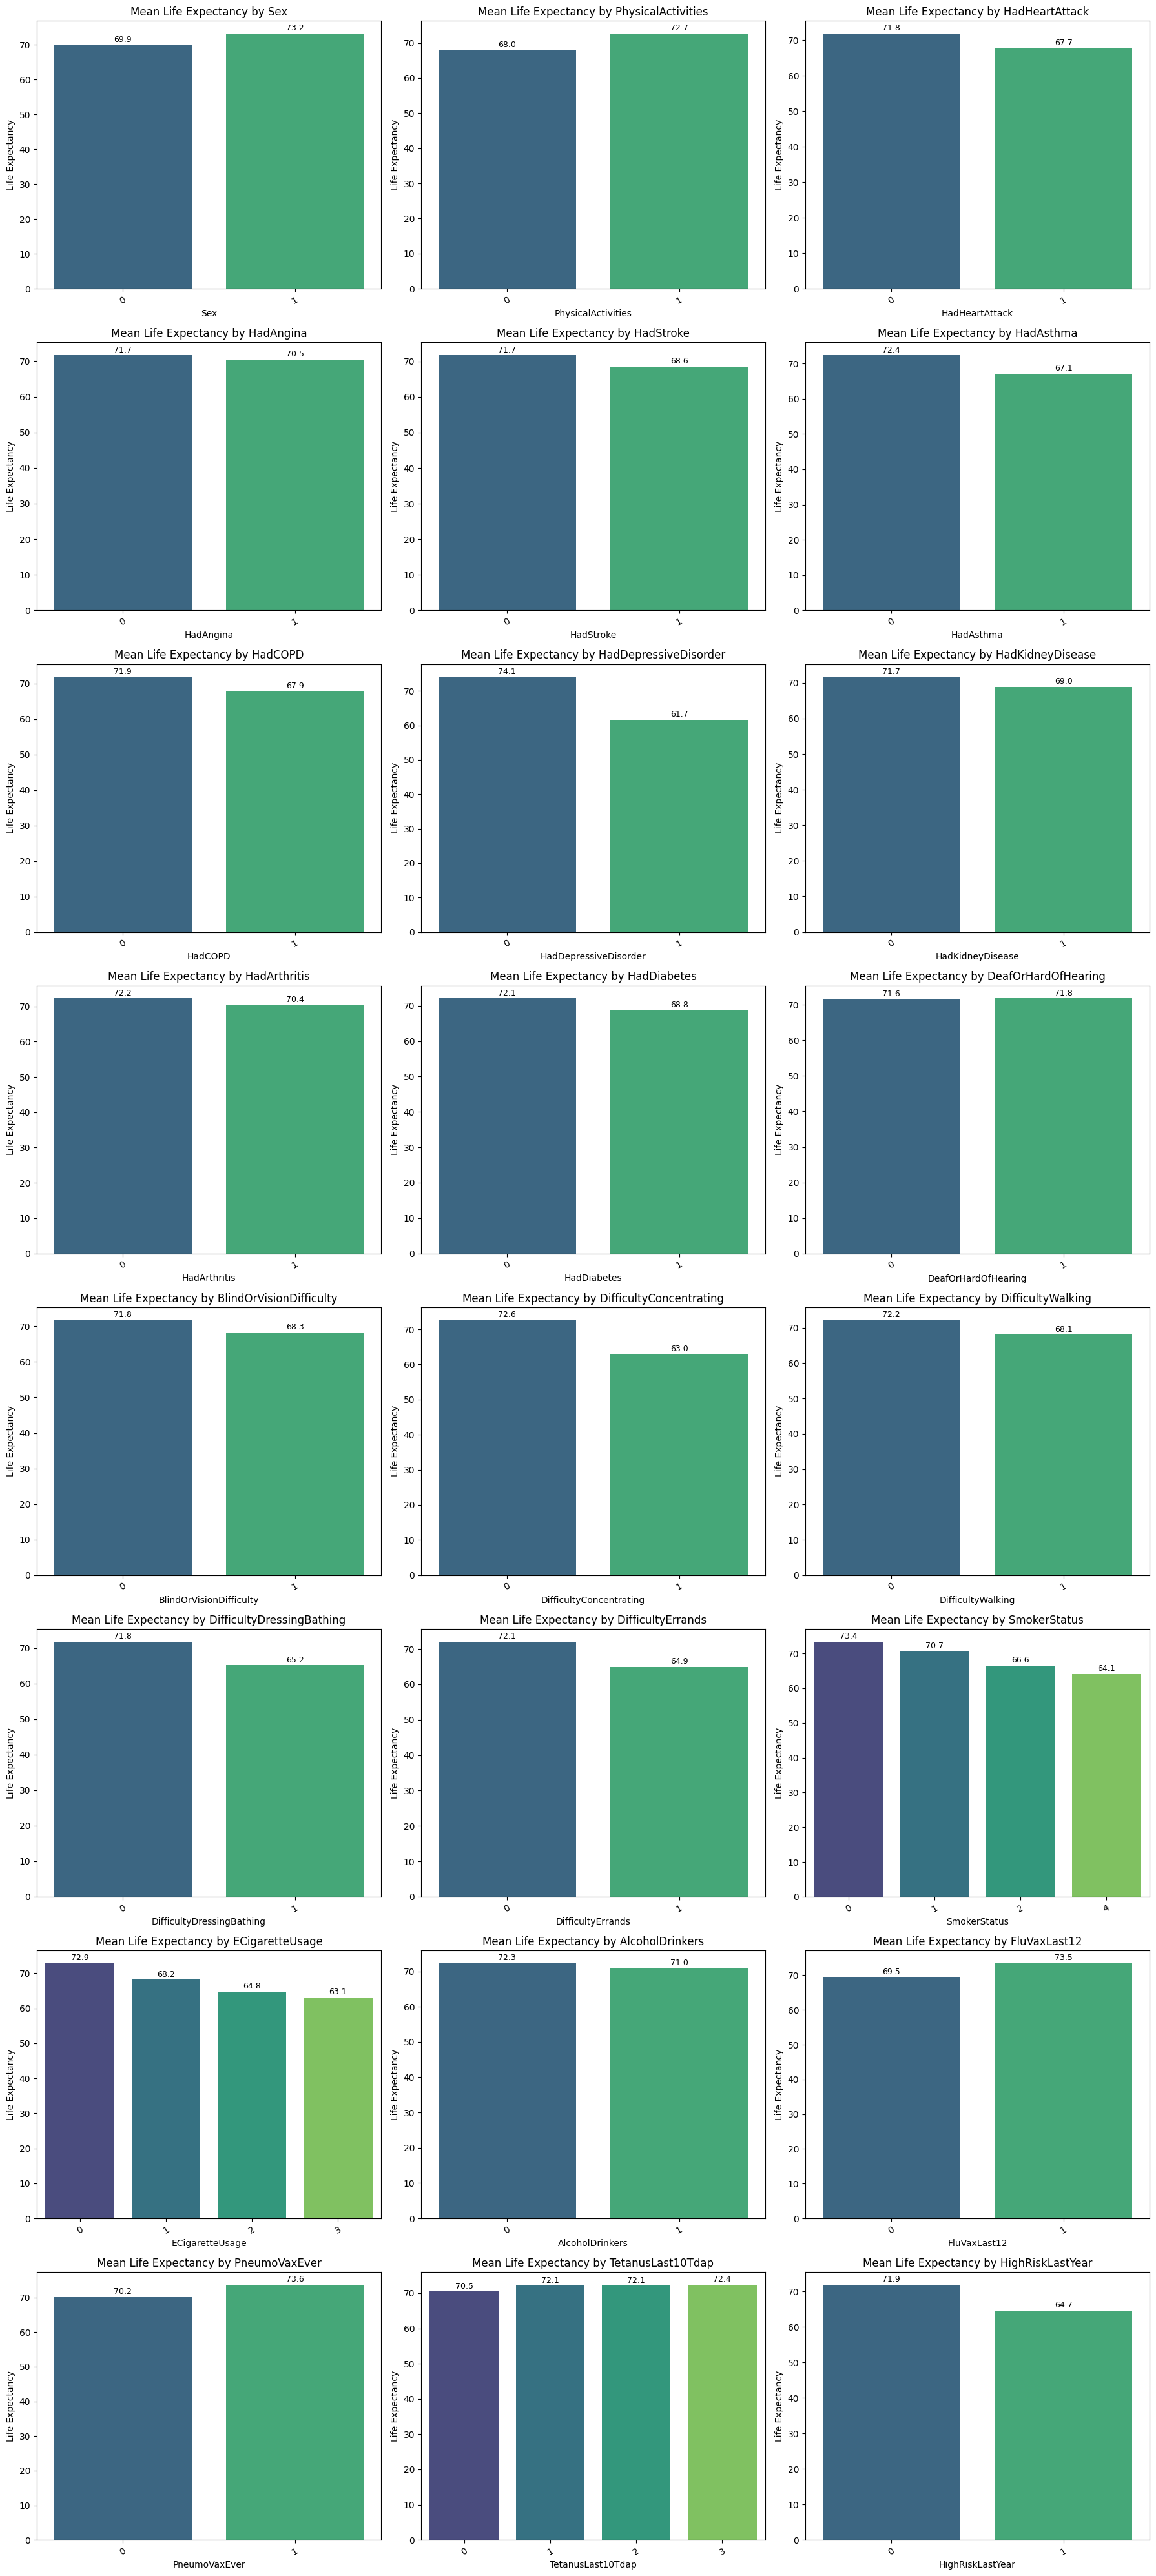

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of indicators to analyze
indicators = [
    'Sex', 'PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke',
    'HadAsthma', 'HadCOPD', 'HadDepressiveDisorder',
    'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing',
    'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking',
    'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
    'ECigaretteUsage', 'AlcoholDrinkers', 'FluVaxLast12', 'PneumoVaxEver',
    'TetanusLast10Tdap', 'HighRiskLastYear'
]

# Set figure size
plt.figure(figsize=(18, 5 * len(indicators) // 3))

for i, col in enumerate(indicators, 1):
    plt.subplot((len(indicators) + 2) // 3, 3, i)

    # Compute mean values
    mean_vals = df.groupby(col)['LifeExpectancy'].mean().reset_index()

    # Barplot with values
    ax = sns.barplot(data=mean_vals, x=col, y='LifeExpectancy', palette='viridis')

    # Add values on top of each bar
    for index, row in mean_vals.iterrows():
        ax.text(index, row['LifeExpectancy'] + 0.3, f"{row['LifeExpectancy']:.1f}",
                color='black', ha='center', va='bottom', fontsize=9)

    plt.title(f'Mean Life Expectancy by {col}')
    plt.ylabel('Life Expectancy')
    plt.xlabel(col)
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

In [21]:
import pandas as pd

corr = df.corr(numeric_only=True)

life_corr = corr['LifeExpectancy'].drop('LifeExpectancy')\
              .sort_values(key=lambda s: s.abs(), ascending=False)

print("Correlation with LifeExpectancy:")
print(life_corr)

Correlation with LifeExpectancy:
HadDepressiveDisorder       -0.519291
DifficultyConcentrating     -0.312855
SmokerStatus                -0.290730
ECigaretteUsage             -0.256664
BMI                         -0.251302
FluVaxLast12                 0.205098
PhysicalActivities           0.201856
HadAsthma                   -0.191711
DifficultyErrands           -0.188472
PneumoVaxEver                0.178047
Sex                          0.168100
SleepHours                   0.157741
DifficultyWalking           -0.154306
HighRiskLastYear            -0.149576
DifficultyDressingBathing   -0.127754
HadCOPD                     -0.111735
HadHeartAttack              -0.098088
HadArthritis                -0.087960
BlindOrVisionDifficulty     -0.079214
TetanusLast10Tdap            0.070946
AlcoholDrinkers             -0.069258
HadStroke                   -0.066458
HadKidneyDisease            -0.060741
HadAngina                   -0.029464
DeafOrHardOfHearing          0.006592
Name: LifeExpecta

In [19]:
df = df.drop(['Age'], axis=1)


In [22]:
df.describe()
df.to_csv('syntatic_data.csv', index=False)